In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
jax.config.update("jax_platform_name", "cpu")

import sys
sys.path.append('..')

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import cloudpickle as pickle

from cge_modeling.gams.gams_constants import AGR_CODES, MFG_CODES, SERV_CODES
from cge_modeling.gams.from_excel import make_code_dicts

del SERV_CODES[SERV_CODES.index('TnD')]

from oecd_model.oecd_calibration import compute_initial_values, calibrate_two_grid_model
from oecd_model.load_oecd_model import load_model
from cge_modeling import CGEModel
import cge_modeling.plotting as cgp

import pandas as pd
import numpy as np

import statsmodels.api as sm


plt.rcParams.update({
    'figure.figsize':(14, 4),
    'figure.dpi':144,
    'axes.grid':True,
    'grid.linewidth':0.5,
    'grid.linestyle':'--',
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False,
})

In [3]:
path = "data/GTAP_raw_data.xlsx"
code_dicts = make_code_dicts(path)

df = pd.read_csv("data/SRB_SAM_full_2grid.csv", index_col=[0, 1], header=[0, 1])
all_variables, all_parameters, all_equations, coords = load_model(df, backend='pytensor', check_model=False)

In [4]:
mod = CGEModel(
    variables=all_variables,
    parameters=all_parameters,
    equations=all_equations,
    coords=coords,
    parse_equations_to_sympy=False,
    use_scan_euler=False,
    backend="pytensor",
    mode="JAX",
    use_sparse_matrices=False,
    compile=None,
)

firm_idxs = mod.coords['i']
elec_idxs = mod.coords['k']

Initializing variables
Initializing parameters
Initializing equations
Initial pre-processing complete, found 20680 equations, 20680 variables, 30811 parameters
Model equations parsed and loaded. Skipping model compilation


In [5]:
inital_values = compute_initial_values(df + 1e-4, mod, init_vals = {'sigma_C':1.5, 'Theta':1.0})
calibrated_data = calibrate_two_grid_model(**inital_values, mod=mod)

In [6]:
with open('data/srb_shock_full_100_steps.p', 'rb') as file:
    res = pickle.load(file)

In [111]:
start = res['euler'].isel(step=0).variables
end = res['euler'].isel(step=-1).variables
pct_change = (end - start) / start
total_pct_change = (end.sum(dim='i') - start.sum(dim='i')) / start.sum(dim='i')

In [8]:
factor_demands = df.loc['Factors', 'Activities']
electricity_demand = factor_demands.loc[['Regulated Electricity', 'Unregulated Electricity']].sum(axis=0)
elec_intensity = electricity_demand / factor_demands.sum(axis=0)
elec_intensity.name = 'elec_intensity'

# Overall Economic Impact

In [9]:
total_pct_change[['Y', 'K_d', 'L_d']].to_array().values

array([0.01702618, 0.01363179, 0.02610831])

In [10]:
to_plot = ['Y', 'K_d', 'L_d', 'E_R_d', 'E_U_d']
short_to_long = {
    'Y':'GDP',
    'K_d':'Capital Demand',
    'L_d':'Labor Demand',
    'E_R_d': 'Regulated Electricity',
    'E_U_d': 'Unregulated Electricity'
}

In [11]:
def double_bar(x, y, ax, color='tab:blue'):
    ax.bar(x, y, facecolor='none', edgecolor='k')
    ax.bar(x, y, color=color, alpha=0.5)

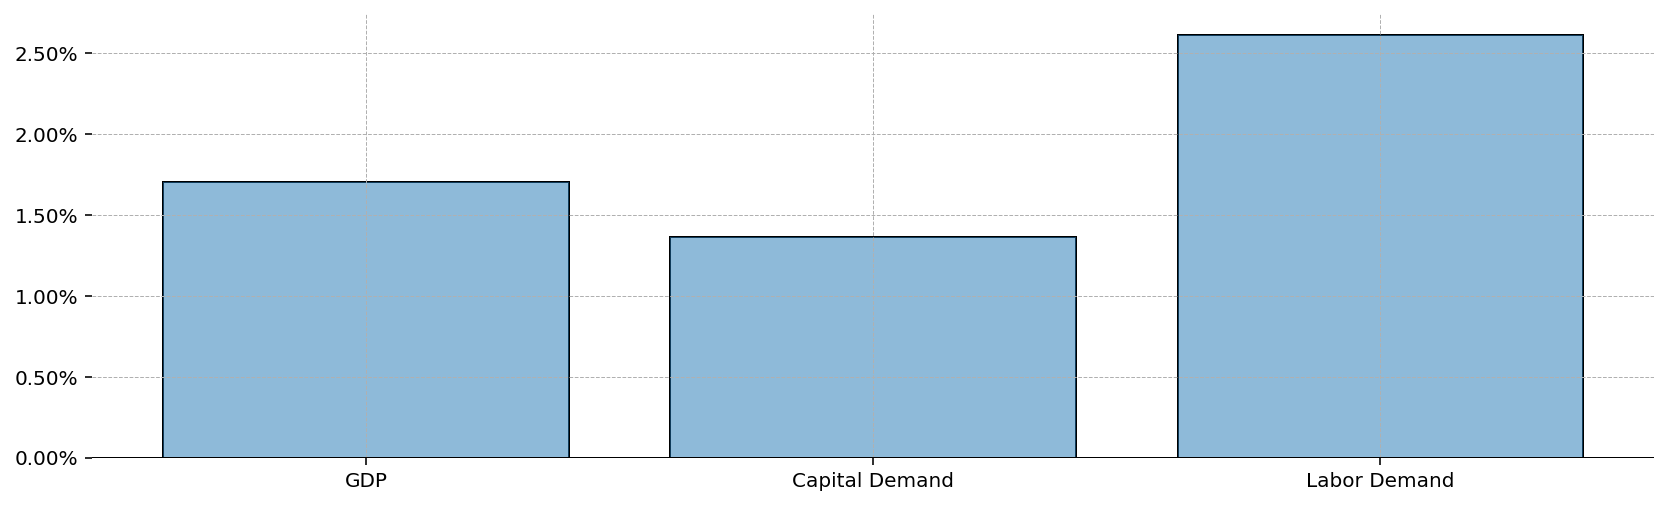

In [99]:
fig, ax = plt.subplots()
ax.axhline(0, c='k')
double_bar(list(map(short_to_long.get, to_plot[:3])), 
           total_pct_change[to_plot[:3]].to_array().values,
           ax)
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

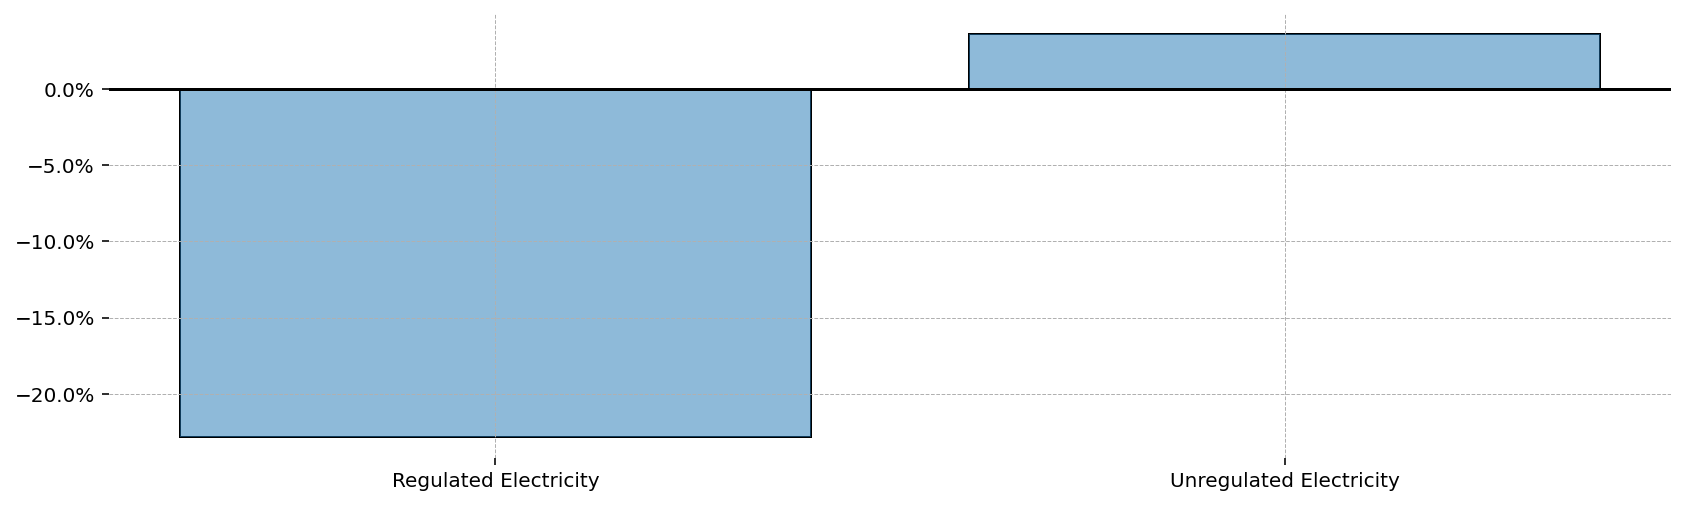

In [104]:
fig, ax = plt.subplots()
ax.axhline(0, c='k')
double_bar(list(map(short_to_long.get, to_plot[3:])), 
           total_pct_change[to_plot[3:]].to_array().values,
           ax)
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

# Sector Level Impacts

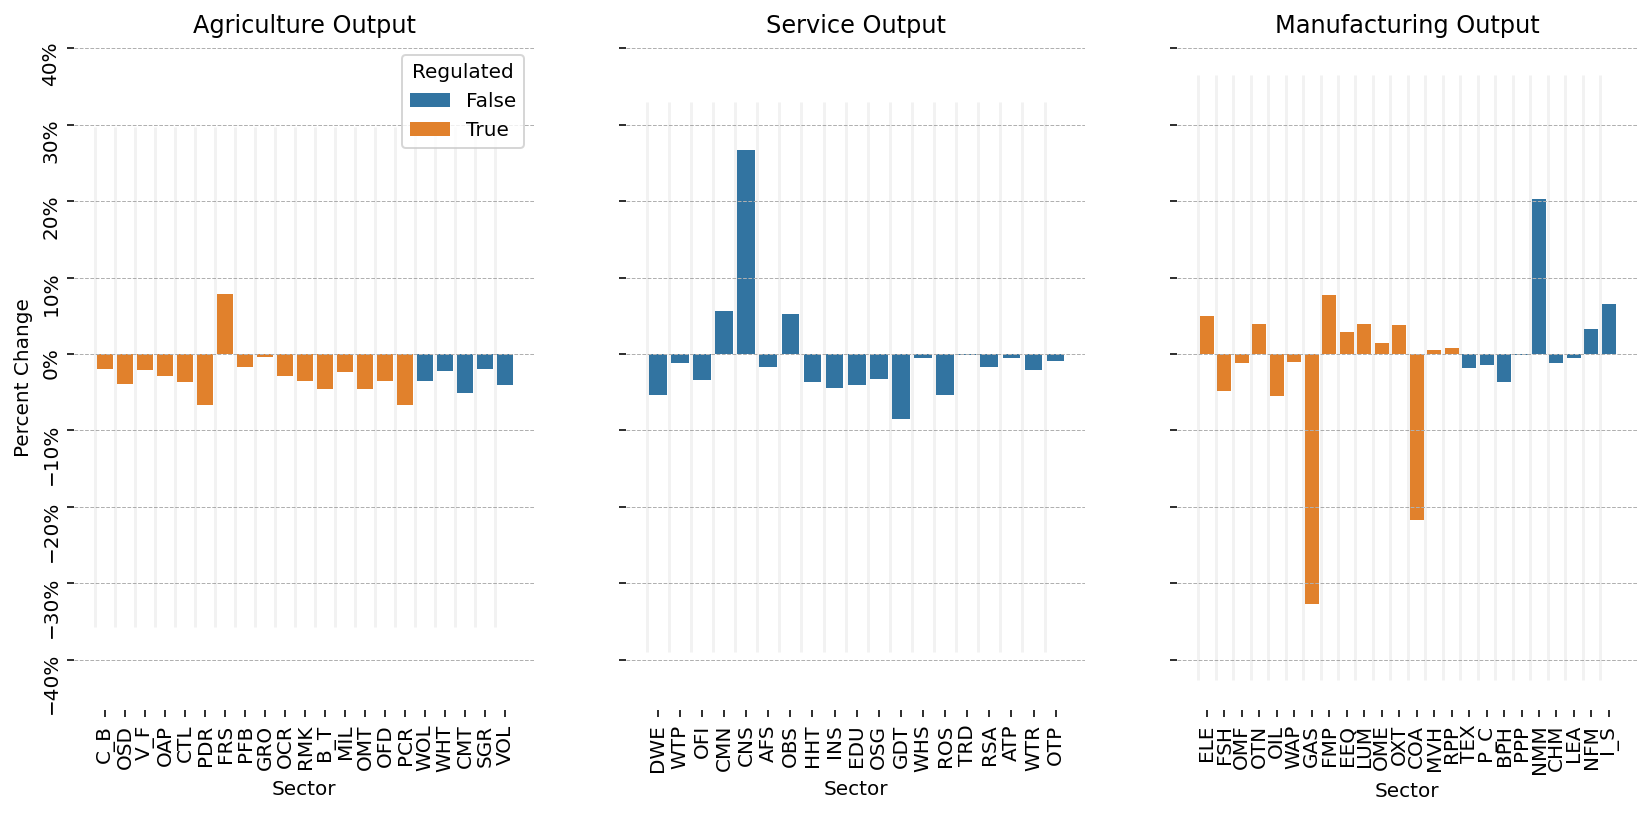

In [100]:
import seaborn as sns
import matplotlib.ticker as mtick

def subsector_and_sector_plots(data):
    group_names = ['Agriculture', 'Service', 'Manufacturing']
    fig, axes = plt.subplots(1, 3, figsize=(14, 6), dpi=144, sharey=True)
    for axis, group, group_name in zip(fig.axes, [AGR_CODES, SERV_CODES, MFG_CODES], group_names):
        sns.barplot((pd.merge((data
                         .to_dataframe()
                         .drop(columns=['step'])
                         .rename(columns=short_to_long)
                         .melt(ignore_index=False, value_name='Percent Change')
                         .reset_index()
                         .rename(columns={'i':'Sector'})
                         .query('Sector in @group')),
             elec_intensity,
             left_on='Sector',
             right_index=True)
                     .sort_values(by='elec_intensity', ascending=True)
                     .assign(Regulated = lambda x: x.elec_intensity < 0.2)),
                    x='Sector',
                    y='Percent Change',
                    hue='Regulated',
                    ax=axis,
                    legend=group_name == 'Agriculture')
        axis.tick_params(rotation=90)
        axis.yaxis.set_major_formatter(mtick.PercentFormatter(1))
        axis.set(title=f'{group_name} Output')
    for axis in fig.axes:
        ylims = axis.get_ylim()
        xlims = axis.get_xlim()
        x_grid = np.arange(*xlims)
        axis.vlines(x_grid, *ylims, alpha=0.1, color='0.5')
    plt.show()
    
subsector_and_sector_plots(pct_change['Y'])

In [19]:
activity_dict = code_dicts['activity']

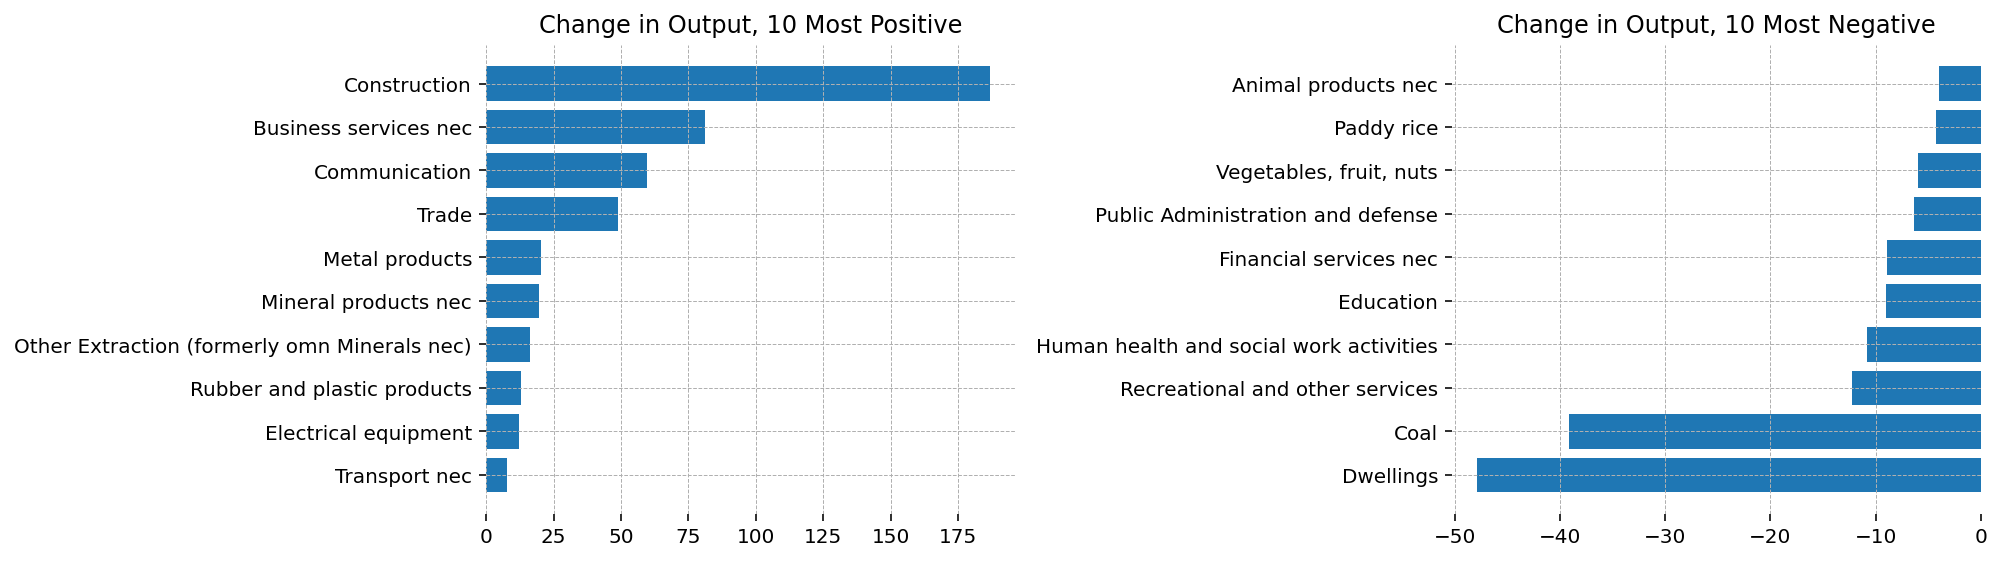

In [113]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
n = 10
titles = [f'Change in Output, {n} Most {group}' for group in ['Positive', 'Negative']]
data_sorted = ((end - start)['L_d']
     .to_dataframe()
#      .drop(columns=['step'])
     .rename(columns=short_to_long)
     .melt(ignore_index=False, value_name='Percent Change')
     .reset_index()
     .rename(columns={'i':'Sector'})
     .sort_values(by='Percent Change'))
bot_k = data_sorted.iloc[:n]
top_k = data_sorted.iloc[-n:]
for axis, data, title in zip(fig.axes, [top_k, bot_k], titles):
    axis.barh(data.Sector.map(activity_dict.get), data['Percent Change'])
    axis.set_title(title)
#     axis.xaxis.set_major_formatter(PercentFormatter(1))
fig.tight_layout()

# Explain Winners/Losers?

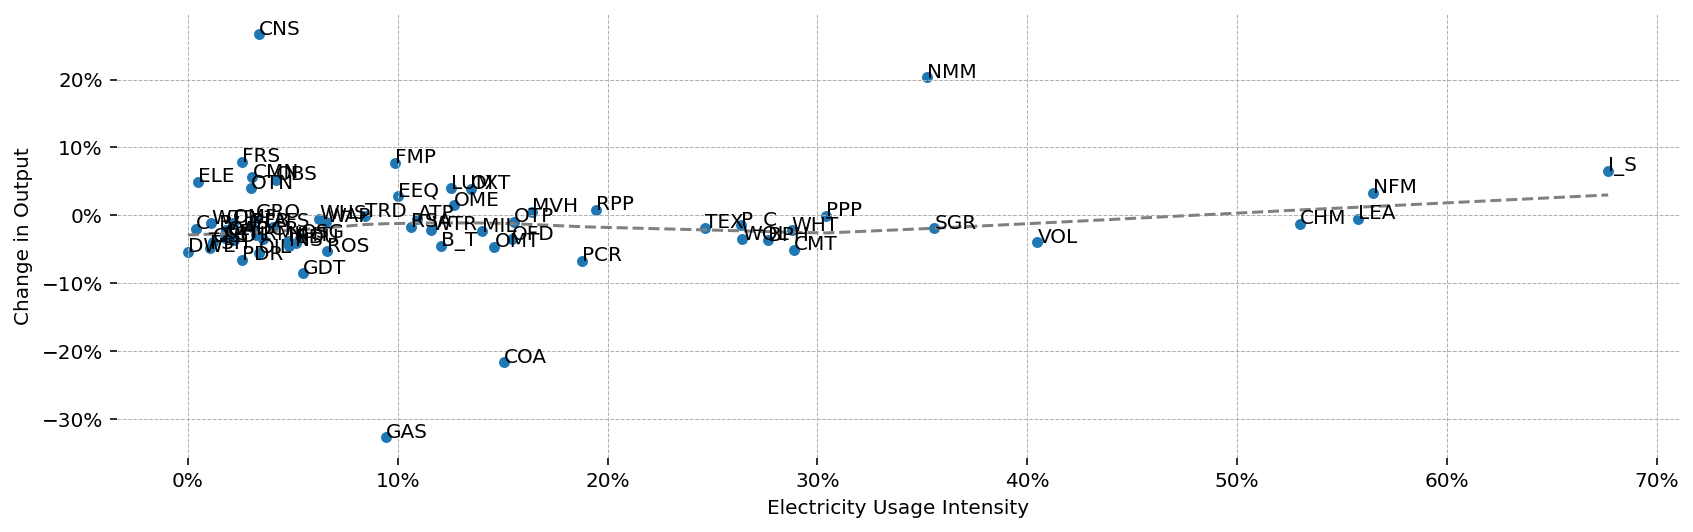

In [28]:
def plot_names_and_lowess(x, y, idxs):    
    fig, ax = plt.subplots()
    lowess = sm.nonparametric.lowess(y[idxs], x[idxs])
    ax.plot(*lowess.T, color='0.5', ls='--')
    ax.scatter(x[idxs], y[idxs], s=20)
    for i in idxs:
        ax.text(x[i], y[i], i)
    return fig, ax
        
fig, ax = plot_names_and_lowess(elec_intensity, pct_change.Y.to_dataframe().Y, firm_idxs)
ax.set(ylabel='Change in Output', xlabel='Electricity Usage Intensity')
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

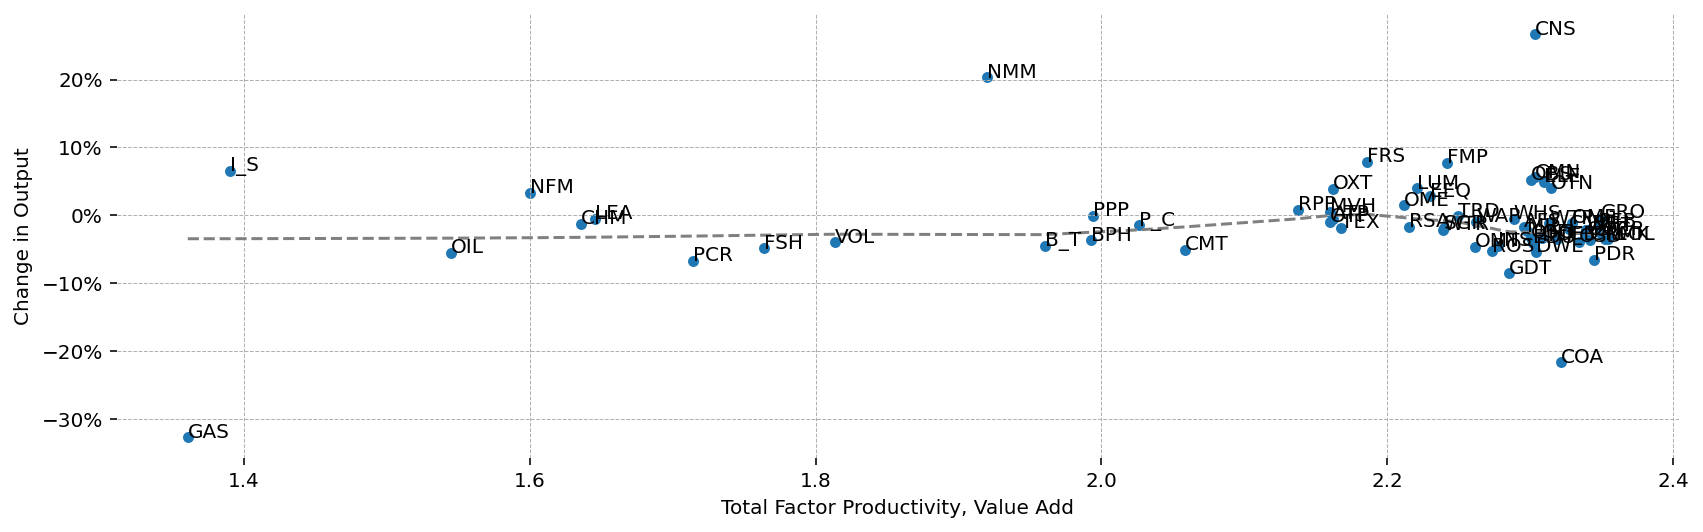

In [43]:
productivity = pd.Series(dict(zip(firm_idxs, calibrated_data['A_VA'])))

fig, ax = plot_names_and_lowess(productivity, pct_change.Y.to_dataframe().Y, firm_idxs)
ax.set(ylabel='Change in Output', xlabel='Total Factor Productivity, Value Add')
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

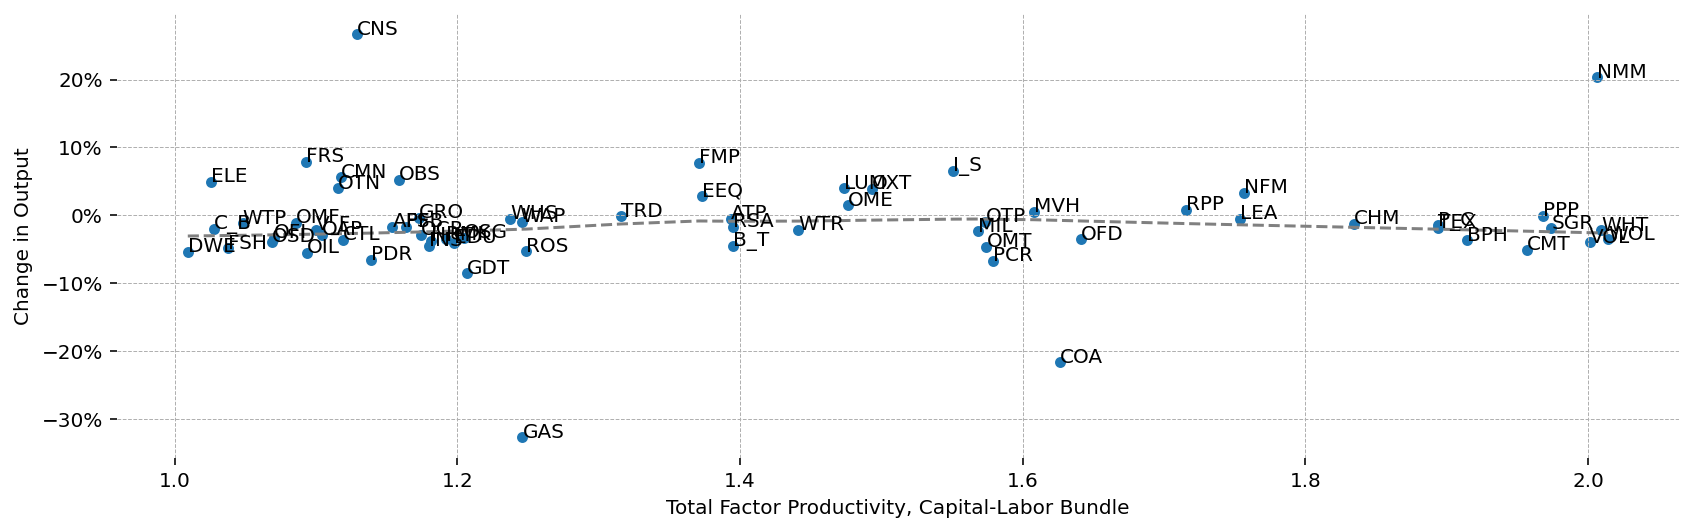

In [44]:
productivity = pd.Series(dict(zip(firm_idxs, calibrated_data['A_KE'])))

fig, ax = plot_names_and_lowess(productivity, pct_change.Y.to_dataframe().Y, firm_idxs)
ax.set(ylabel='Change in Output', xlabel='Total Factor Productivity, Capital-Labor Bundle')
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

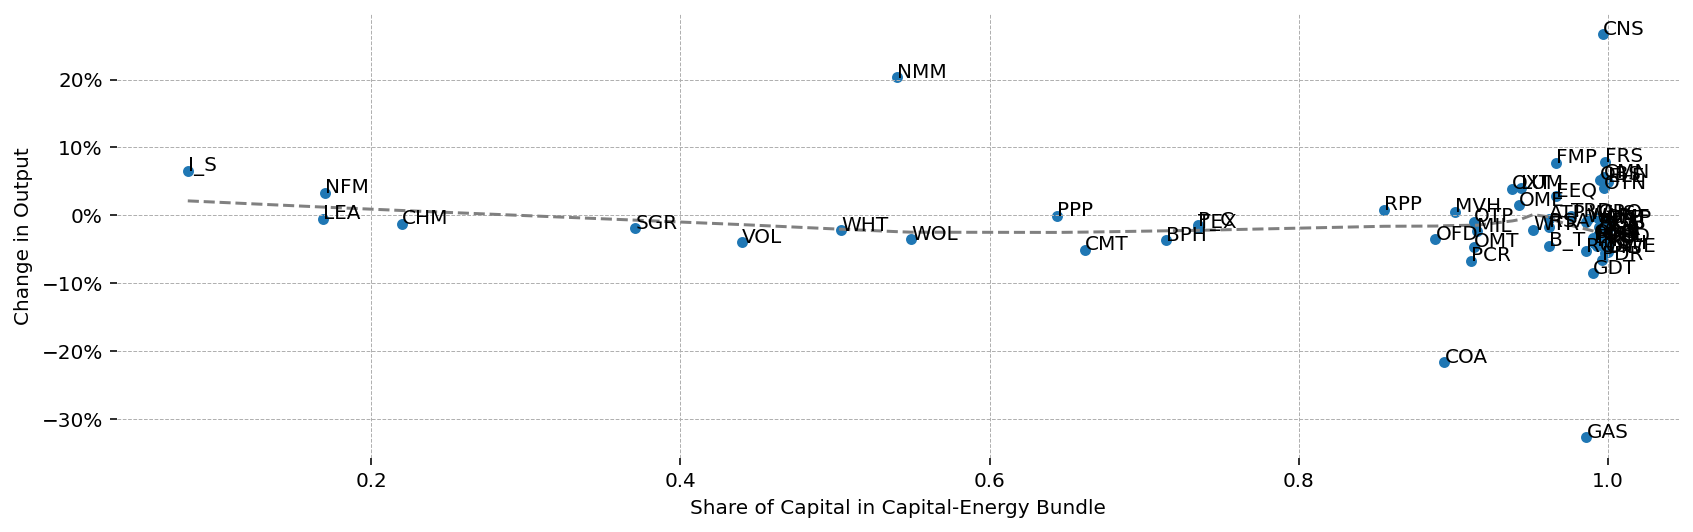

In [61]:
productivity = pd.Series(dict(zip(firm_idxs, calibrated_data['alpha_KE'])))

fig, ax = plot_names_and_lowess(productivity, pct_change.Y.to_dataframe().Y, firm_idxs)
ax.set(ylabel='Change in Output', xlabel='Share of Capital in Capital-Energy Bundle')
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

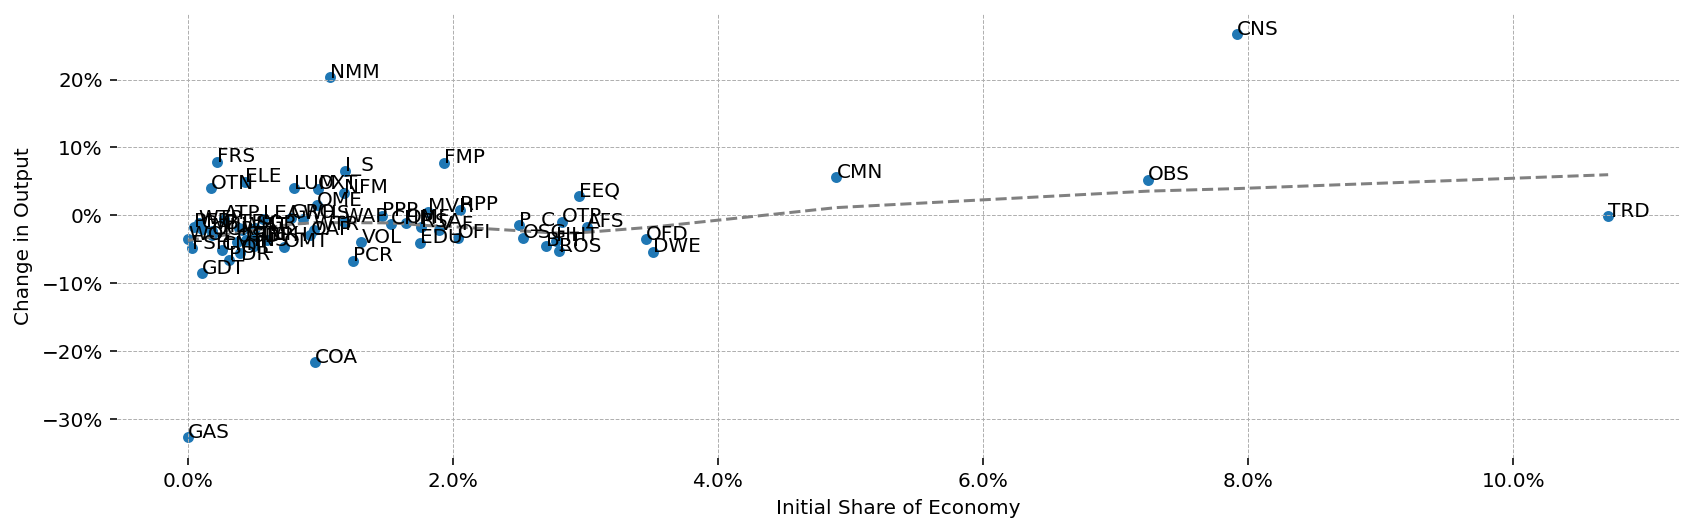

In [40]:
economy_share = inital_values['Y'] / inital_values['Y'].sum()
fig, ax = plot_names_and_lowess(economy_share, pct_change.Y.to_dataframe().Y, firm_idxs)
ax.set(ylabel='Change in Output', xlabel='Initial Share of Economy')
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

# Trace through model space

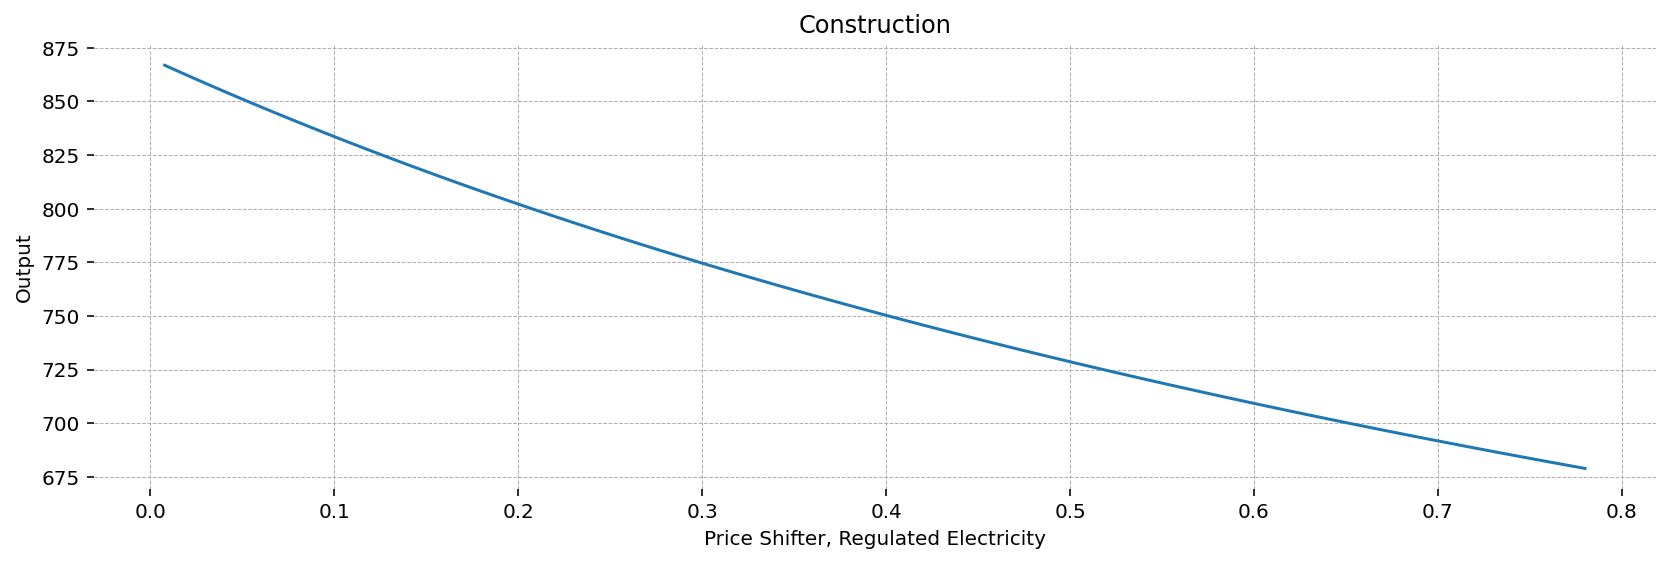

In [115]:
x = res['euler'].parameters.P_E_R_bar.values

y1 = res['euler'].variables.Y.sel(i='CNS').values
y2 = res['euler'].variables.Y.sel(i='COA').values

fig, ax = plt.subplots()
ax.plot(x, y2)
ax.set(xlabel='Price Shifter, Regulated Electricity', ylabel='Output', title=activity_dict['CNS'])
plt.show()

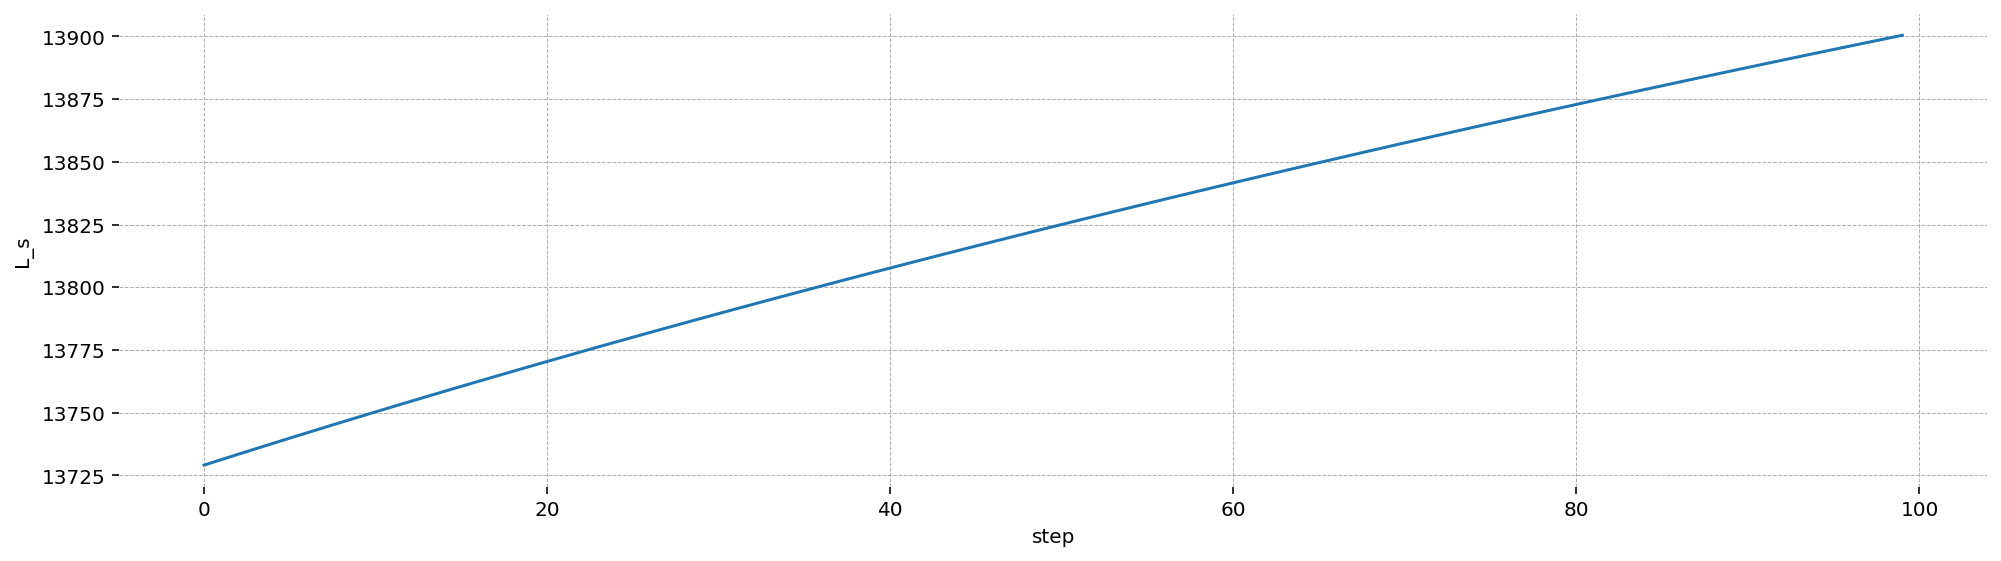

In [118]:
cgp.plot_lines(res, mod, var_names=['L_s'], 
               plot_optimizer=False, 
               figsize=(14,4));